# ECR Gate calibration with model-free RL (Pulse level simulation)

In this notebook, we will train a reinforcement learning agent to learn pulse level control of a quantum system. The configuration is drawn from two dedicated yaml files respectively describing the quantum environment and the agent. The quantum environment is a `QuantumEnvironment` object, which is a subclass of `gym.Env ` and is designed to be compatible with standard RL libraries. The agent on the other hand, is specifically hard coded for our need because of the need to be able to send to the same resource (the Estimator primitive) a batch of quantum circuits (in contrast with usual RL frameworks where actions can be evaluated in parallel).

For this notebook, we take all necessary inputs from the `ecr_cal_config.py` file. This python file contains all elements necessary to create a pulse-level quantum environment. The file contains the following elements:
- a parametrized gate function, coded through Qiskit; leveraging behind the scenes a custom parametrized pulse schedule, to be inserted in the quantum circuit. The function needs to modify an input parametrized quantum circuit, by appending the parametrized gate to it.
- a Qiskit backend object, which is the quantum device or simulator on which the quantum circuits will be executed. The backend is retrieved through another template function called `get_backend`.
- A circuit context, which is a `QuantumCircuit` object that contains the quantum circuit in which the target gate operation should be optimized. The context is used to create the `ContextAwareQuantumEnvironment` object, which is a subclass of `BaseQuantumEnvironment` that takes into account the context of the quantum circuit in which the gate is to be optimized. Note that this mode is optional, as one could just focus on optimizing the gate operation in a standalone manner (i.e., without any context).

We provide a dedicated template for IBM devices working through ECR, X, and SX basis gates. The user can adapt this to the platform and basis gates of his choice.

For this notebook, we will focus on the calibration of an Echoed Cross Resonance (ECR) gate.

In [1]:
from qiskit.primitives import BackendEstimatorV2

%matplotlib inline
from pulse_level.qiskit_pulse.ecr_calibration.ecr_cal_config import (
    get_backend,
    apply_parametrized_circuit,
    get_circuit_context,
)
from rl_qoc import ContextAwareQuantumEnvironment, QuantumEnvironment, CustomPPO
from gymnasium.wrappers import RescaleAction, ClipAction
from qiskit.circuit import QuantumCircuit
from rl_qoc.helper_functions import (
    simulate_pulse_schedule,
    load_from_yaml_file,
    get_q_env_config,
)
import numpy as np

# Quantum Environment Configuration
The quantum environment configuration is drawn from a yaml file. The configuration file contains the following elements:
- Backend information: All the information necessary to retrieve the backend object from Qiskit.
- Target information: The target to prepare, which can be a quantum gate or a quantum state. The target is described by the name of the gate or the state (e.g., 'x' for the X gate), and the physical qubit indices on which the gate is to be applied.
- Environment information: The hyperparameters of the quantum environment such as:
    - Execution parameters: 
        - `N_SHOTS`: The number of shots for the quantum circuit execution
        - `SAMPLING_PAULIS`: The number of Pauli strings to sample for the expectation value estimation 
        - `N_REPS`: The number of repetitions of the target operation/circuit context to amplify the noise
        - `BATCH_SIZE`: The number of circuits to be sent to the quantum device in parallel to evaluate the policy
        - `SEED`: The seed for the quantum environment
    - Action space parameters: Specify the parameters range of the action space (i.e. range of pulse parameters)
        - `LOW`: The lower bound of the action space
        - `HIGH`: The upper bound of the action space
    - Reward scheme: The reward scheme to evaluate the performance of the agent
        - `REWARD_METHOD`: The reward method to use. The available options are (`'fidelity'`, `cafe`, `channel`, `state`, `orbit`)
        - `REWARD_PARAMS`: The parameters of the reward method (each reward method has its own parameters)
    - Benchmarking: The benchmarking parameters to evaluate the performance of the agent
        - `BENCHMARK_CYCLE`: The number of updates after which the benchmarking is done
        - `BENCHMARK_BATCH_SIZE`: The number of circuits to be sent to the quantum device in parallel to evaluate the policy during benchmarking
        - `CHECK_ON_EXP`: A flag to indicate if benchmarking should be done through an experiment (such as State/Process Tomography) or through a simulation
                - If `True`, the benchmarking is done through an experiment
                - If `False`, the benchmarking is done through a simulation
      


In [2]:
# Get the quantum environment configuration
import os

current_dir = os.getcwd()
config_file_name = "ecr_pulse_cal.yaml"
# Do not touch part below, just import in your notebook q_env_config and circuit_context
config_file_address = os.path.join(current_dir, config_file_name)

q_env_config = get_q_env_config(
    config_file_address,
    get_backend,
    apply_parametrized_circuit,
)
q_env_config.backend_config.parametrized_circuit_kwargs = {
    "target": q_env_config.target,
    "backend": q_env_config.backend,
}
circuit_context = get_circuit_context(
    q_env_config.backend, q_env_config.physical_qubits
)

Custom backend used
Starting Rabi experiment for qubit 0...
Rabi experiment for qubit 0 done.
Starting Drag experiment for qubit 0...
Drag experiments done for qubit 0 done.
Starting Rabi experiment for qubit 1...
Rabi experiment for qubit 1 done.
Starting Drag experiment for qubit 1...
Drag experiments done for qubit 1 done.
All single qubit calibrations are done
Updated Instruction Schedule Map <InstructionScheduleMap(1Q instructions:
  q0: {'h', 'reset', 'tdg', 'delay', 's', 'rz', 'sx', 't', 'id', 'z', 'x', 'measure', 'sdg'}
  q1: {'h', 'reset', 'tdg', 'delay', 's', 'rz', 'sx', 't', 'id', 'z', 'x', 'measure', 'sdg'}
Multi qubit instructions:
  (0, 1): {'cr45m', 'ecr', 'cr45p'}
  (1, 0): {'cr45m', 'ecr', 'cr45p'}
)>
Circuit context: 
         ┌───┐ ░ ┌─────┐          ┌──────┐┌───┐┌───┐┌─────┐┌──────┐┌───┐
q_0 -> 0 ┤ H ├─░─┤ Sdg ├──────────┤0     ├┤ X ├┤ H ├┤ Sdg ├┤0     ├┤ X ├
         └───┘ ░ └┬───┬┘┌───┐┌───┐│  Ecr │├───┤├───┤└┬───┬┘│  Ecr │└───┘
q_1 -> 1 ──────░──┤ S ├─┤ H ├┤ S ├┤

In [3]:
# Set the use_context flag to True if you want to use the context of the quantum circuit
use_context = False

if use_context:
    q_env = ContextAwareQuantumEnvironment(
        q_env_config, circuit_context, training_steps_per_gate=250
    )
else:
    q_env = QuantumEnvironment(q_env_config)

# Rescale the action space to [-1, 1] and clip the actions to the valid range
# This step is dependent on the output layer of the agent for the mean of the policy
# If the output layer is a tanh layer (default), then rescaling is necessary
rescaled_env = RescaleAction(ClipAction(q_env), -1.0, 1.0)

In [4]:
from qiskit.visualization import plot_circuit_layout

print("Available operations", q_env.backend.operation_names)
try:
    plot_circuit_layout(circuit_context, backend=q_env.backend)
except:
    print("No layout available")

Available operations ['measure', 'z', 's', 'sdg', 't', 'tdg', 'rz', 'id', 'h', 'x', 'sx', 'reset', 'delay', 'ecr', 'cr45p', 'cr45m', 'ecr_cal']


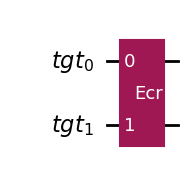

In [5]:
# Draw the target circuit
q_env.baseline_circuits[0].draw("mpl")

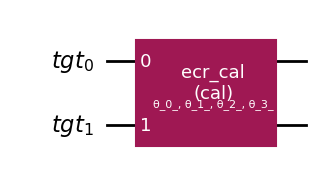

In [6]:
# Draw the parametrized circuit
circuit = q_env.circuits[0]
circuit.draw("mpl")

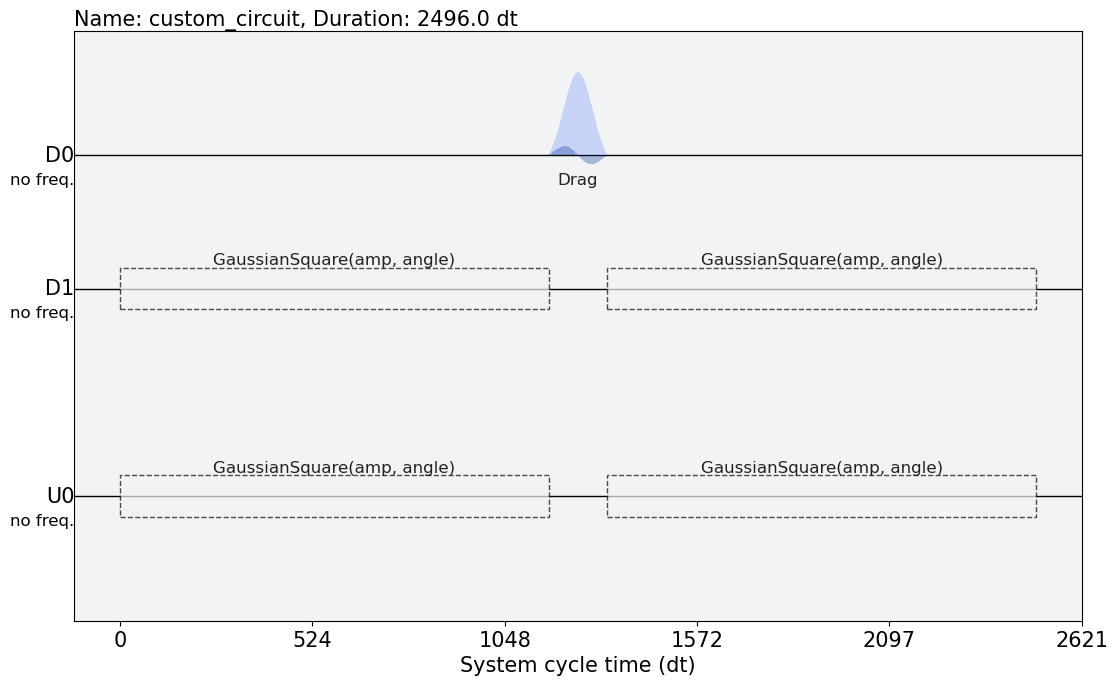

In [8]:
from qiskit import schedule

schedule(circuit, q_env.backend).draw()

# Agent Configuration
The agent configuration is drawn from a yaml file. The configuration file contains the following elements:

- **RUN\_NAME**: Name of the run.
- **OPTIMIZER**: Optimizer for the policy network (e.g., `adam`).
- **NUM\_UPDATES**: Number of policy updates.
- **N\_EPOCHS**: Number of epochs for each policy update.
- **MINIBATCH\_SIZE**: Number of samples per mini-batch.
- **LR**: Learning rate.
- **GAMMA**: Discount factor.
- **GAE\_LAMBDA**: Lambda coefficient for Generalized Advantage Estimation.
- **ENT\_COEF**: Entropy coefficient.
- **V\_COEF**: Value (critic) function coefficient.
- **GRADIENT\_CLIP**: Gradient clipping value.
- **CLIP\_VALUE\_LOSS**: Whether to clip value loss (boolean).
- **CLIP\_VALUE\_COEF**: Clipping coefficient for value loss.
- **CLIP\_RATIO**: Clipping ratio for Proximal Policy Optimization (PPO).
- **N\_UNITS**: Number of units in hidden layers (list of integers).
- **ACTIVATION**: Activation function (e.g., `tanh`).
- **INCLUDE\_CRITIC**: Whether to include critic network within Actor-Critic model (boolean).
- **NORMALIZE\_ADVANTAGE**: Whether to normalize advantage (boolean).
- **CHKPT\_DIR**: Directory to save checkpoints.

In [7]:
from pathlib import Path

# Change the file_name to the name of the agent configuration file and specify the file location
file_name = "agent_config.yaml"
file_location = Path.cwd() / file_name

agent_config = load_from_yaml_file(file_location)

In [8]:
ppo_agent = CustomPPO(agent_config, rescaled_env)

## Training loop configuration
We furthermore provide some tools to control the training loop. You can for example choose which constraint should stop the training loop. It can either be a total number of updates for the policy, or alternatively a wall clock time (in seconds) that would be reached if you were to do this experiment in the lab (we internally track the duration of each circuit based on the durations of each operation, including measurements and resets).

In [9]:
from rl_qoc.ppo_config import TotalUpdates, TrainFunctionSettings, TrainingConfig

total_updates = TotalUpdates(500)
# hardware_runtime = HardwareRuntime(300)
training_config = TrainingConfig(
    training_constraint=total_updates,
    target_fidelities=[0.999, 0.9999],
    lookback_window=10,
    anneal_learning_rate=True,
    std_actions_eps=1e-2,
)

train_function_settings = TrainFunctionSettings(
    plot_real_time=True,
    print_debug=True,
    num_prints=1,
    hpo_mode=False,
    clear_history=False,
)

In [10]:
ppo_agent.ent_coef = 0.01
q_env.estimator = BackendEstimatorV2(backend=q_env.backend)

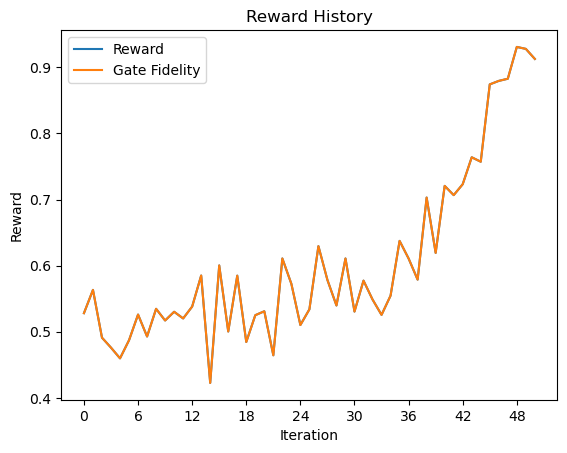

 10%|█         | 51/500 [05:11<45:57,  6.14s/it]

Starting simulation benchmark...


 10%|█         | 51/500 [05:17<46:33,  6.22s/it]


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [10]:
# Launch the training (note: you can interrupt it at any time and retrieve the training_results as an attribute of the ppo_agent).
training_results = ppo_agent.train(
    training_config=training_config, train_function_settings=train_function_settings
)

# Benchmarking the quality of the obtained calibration

We derive a series of experiments and simulations below enabling the assessment of the optimal action (i.e. the one that yielded the maximum reward) obtained by the agent.

In [11]:
print("Optimal action", q_env.optimal_action)
print("Best fidelity:", np.max(q_env.fidelity_history))

Optimal action [ 0.49896565  0.13461351  0.2949589  -3.1293163 ]
Best fidelity: 0.9309331406365751


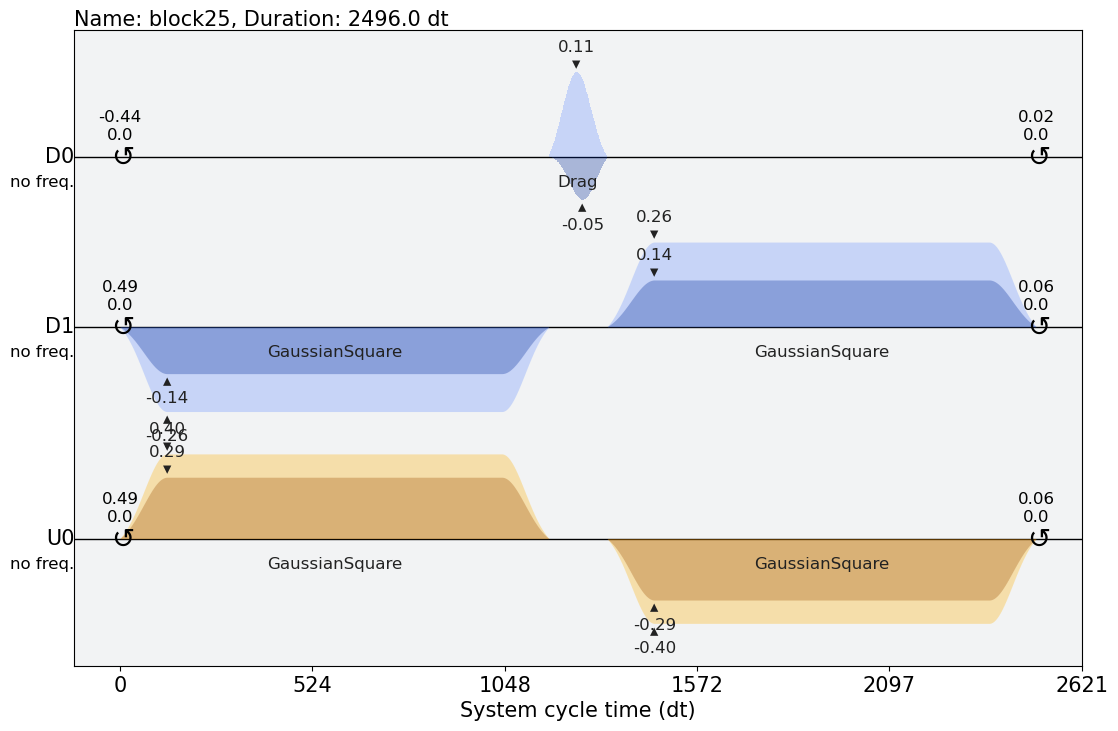

In [12]:
# Update the gate calibration in the backend target and visualize the calibration
from qiskit.visualization.pulse_v2 import IQXDebugging

custom_name = None
optimal_calibration = q_env.update_gate_calibration(custom_name)
optimal_calibration.draw(style=IQXDebugging())

In [13]:
q_env.backend.target.operation_names

dict_keys(['measure', 'z', 's', 'sdg', 't', 'tdg', 'rz', 'id', 'h', 'x', 'sx', 'reset', 'delay', 'ecr', 'cr45p', 'cr45m', 'ecr_cal'])

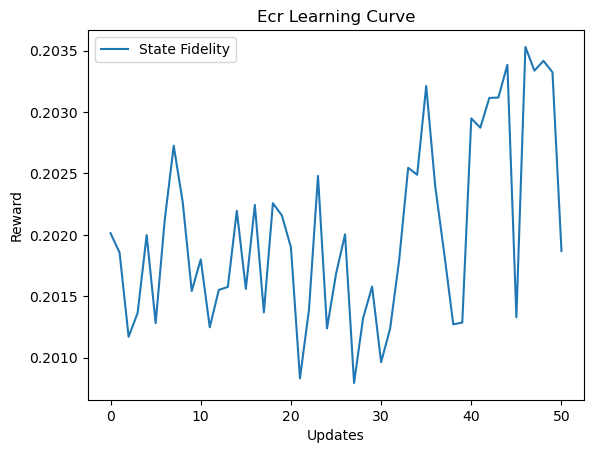

In [14]:
from rl_qoc import GateTarget
import matplotlib.pyplot as plt

reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = int(np.max(mean_rewards) * 1e4) / 1e4
n_epochs = len(mean_rewards)
if q_env.benchmark_cycle != 0:
    fidelity_range = np.arange(0, n_epochs, q_env.benchmark_cycle)
# plt.plot(
#     # fidelity_range,
#     np.array(q_env.fidelity_history),
#     label=f"{q_env.target.target_type.capitalize()} Fidelity",
# )
plt.plot(np.array(q_env.circuit_fidelity_history), label="State Fidelity")
# plt.plot(mean_rewards, label=f"Average Rewards, max: {max_mean}")

plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(
    f"{q_env.target.gate.name.capitalize() if isinstance(q_env.target, GateTarget) else ''} Learning Curve"
)
plt.legend()
plt.show()

In [15]:
# Simulate the circuit binded with the optimal action
fidelity = q_env.simulate_pulse_circuit(q_env.circuits[0], [q_env.optimal_action])
print(f"{q_env.target.target_type.capitalize()} Fidelity: {fidelity}")
print("State fidelity: ", np.max(q_env.circuit_fidelity_history))
print("Index of max state fidelity: ", np.argmax(q_env.circuit_fidelity_history))
print("Gate fidelity: ", np.max(q_env.avg_fidelity_history))
print("Index of max gate fidelity: ", np.argmax(q_env.avg_fidelity_history))

Gate Fidelity: [0.9388655240049513]
State fidelity:  0.20584338310167744
Index of max state fidelity:  51
Gate fidelity:  0.9388655240049513
Index of max gate fidelity:  51


/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/rl_qoc/base_q_env.py:474: UserWarning: Input state is not normalized (norm = 0.9999999999999999)
  warnings.warn(


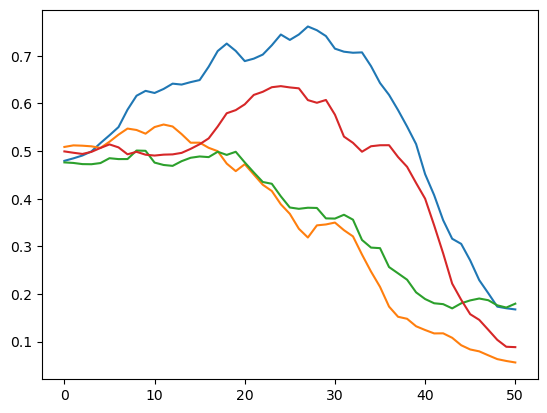

In [16]:
import matplotlib.pyplot as plt

# Check that the agent has converged to an optimal action by plotting the mean and std of the multivariate Gaussian policy
plt.plot(ppo_agent.training_results["std_action"])

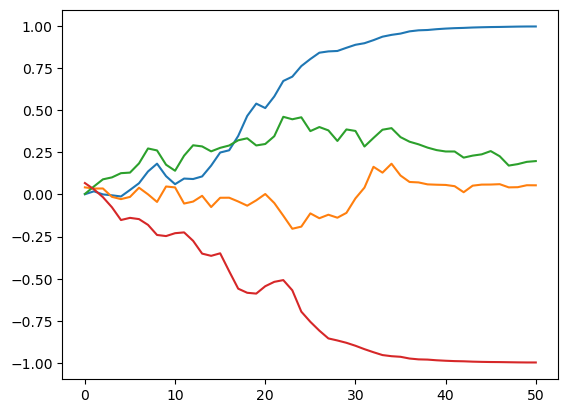

In [17]:
plt.plot(ppo_agent.training_results["action_history"])

In [18]:
from pulse_level.qiskit_pulse.ecr_calibration.ecr_cal_config import custom_schedule

cal = custom_schedule(
    q_env.backend, q_env.physical_target_qubits, q_env.parameters
).assign_parameters({q_env.parameters: q_env.optimal_action.tolist()})
data = simulate_pulse_schedule(
    q_env.backend, cal, target_unitary=q_env.target.target_operator
)

print(data)

{'unitary': Operator([[ 1.66236844e-01+0.03586688j,  7.97357463e-03+0.53086743j,
           -3.64169461e-03-0.04695101j, -8.29353287e-01-0.04516676j],
          [ 2.55431861e-01+0.4665486j ,  1.26106034e-01-0.14102054j,
            7.15803593e-01-0.41234449j,  2.66889947e-04+0.04264374j],
          [ 8.09451951e-03-0.03672492j, -7.45558247e-01-0.35683587j,
            1.32799802e-01+0.13543166j, -2.69583066e-01+0.45789553j],
          [ 8.30278692e-01+0.01713323j,  6.29542836e-03+0.04491279j,
            7.03314076e-03+0.53128968j,  1.67462878e-01-0.02877947j]],
         input_dims=(2, 2), output_dims=(2, 2)), 'state': DensityMatrix([[ 2.89211213e-02-1.03089444e-19j,
                 5.91958284e-02-6.83960227e-02j,
                 2.83989636e-05+6.39536071e-03j,
                 1.38637425e-01+2.69313314e-02j],
               [ 5.91958284e-02+6.83960227e-02j,
                 2.82913028e-01-1.16137925e-18j,
                -1.50663638e-02+1.31572026e-02j,
                 2.20073115e-

In [19]:
from qiskit.quantum_info import Operator, Statevector

data = simulate_pulse_schedule(
    q_env.backend,
    optimal_calibration,
    target_unitary=q_env.target.target_operator,
    target_state=Statevector(
        q_env.baseline_circuits[0].remove_final_measurements(inplace=False)
    ),
)
print(data)

{'unitary': Operator([[ 0.18873996+0.04676872j,  0.23648313+0.47285595j,
           -0.00604832-0.03029587j, -0.82331528-0.08213116j],
          [ 0.02744064+0.52831659j,  0.14162137-0.10684525j,
            0.75979125+0.33644474j, -0.00545282+0.03243506j],
          [ 0.00461435-0.02985296j, -0.73264945+0.39317446j,
            0.14513287+0.10034098j, -0.04352901+0.52688783j],
          [ 0.82696396-0.02035435j,  0.00156355+0.02375454j,
           -0.22326929+0.48007164j,  0.19037834-0.03835893j]],
         input_dims=(2, 2), output_dims=(2, 2)), 'state': DensityMatrix([[ 3.78100869e-02+6.97771719e-19j,
                 2.98878385e-02-9.84310901e-02j,
                -5.25272959e-04+5.85025291e-03j,
                 1.55129200e-01+4.25177283e-02j],
               [ 2.98878385e-02+9.84310901e-02j,
                 2.79871412e-01-6.80041013e-19j,
                -1.56451914e-02+3.25702041e-03j,
                 1.19388815e-02+4.37457321e-01j],
               [-5.25272959e-04-5.85025291e

## Benchmarking within a QuantumCircuit (over counts)

In [20]:
from qiskit.transpiler import Target

tgt: Target = q_env.backend.target
tgt.operations

[Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]),
 Instruction(name='z', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='s', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='sdg', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='t', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='tdg', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='rz', num_qubits=1, num_clbits=0, params=[Parameter(λ)]),
 Instruction(name='id', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='h', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='x', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='sx', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='reset', num_qubits=1, num_clbits=0, params=[]),
 Delay(duration=t[unit=dt]),
 Instruction(name='ecr', num_qubits=2, num_clbits=0, params=[]),
 Instruction(name='cr45p', num_qubits=2, num_clbits=0, params=[]),
 Instruction(name='cr45m', num_qubits=2, num_clbits=0,

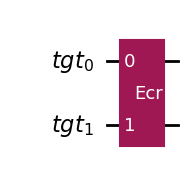

In [21]:
q_env.baseline_circuits[0].draw("mpl")

In [22]:
# Testing gate in a quantum circuit
from qiskit.providers.basic_provider import BasicSimulator
from qiskit import transpile

qc = QuantumCircuit(2)
qc.x(0)
qc.h(1)
qc.ecr(0, 1)
qc.measure_all()
qc.draw("mpl")

basic_simulator = BasicSimulator()
basic_result = basic_simulator.run(qc, shots=10000).result()

pulse_circ = transpile(qc, q_env.backend)
q_env.backend.options.shots = 10000
pulse_results = q_env.backend.run(pulse_circ).result()

print("BasicProvider: ", basic_result.get_counts())
print("Custom Backend:", pulse_results.get_counts())

BasicProvider:  {'00': 5040, '10': 4960}
Custom Backend: {'00': 6704, '01': 342, '10': 2389, '11': 565}


Original circuit


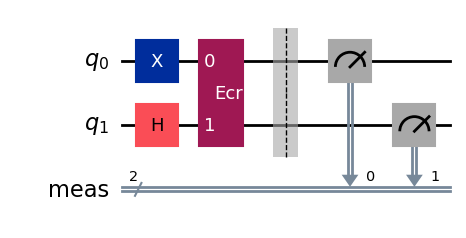

In [23]:
print("Original circuit")
qc.draw("mpl")

Transpiled circuit


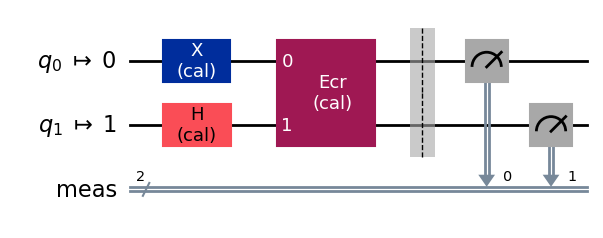

In [24]:
print("Transpiled circuit")
pulse_circ.draw("mpl")

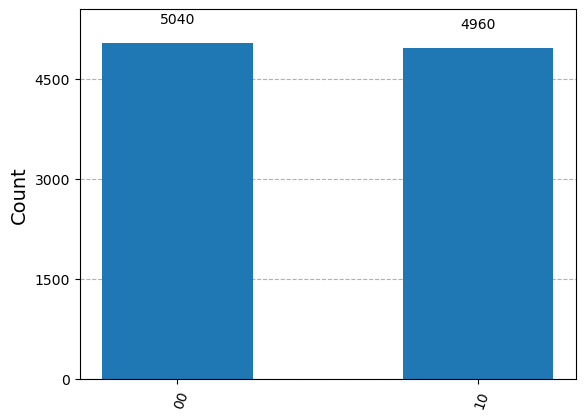

In [25]:
from qiskit.visualization import plot_histogram

plot_histogram(basic_result.get_counts())

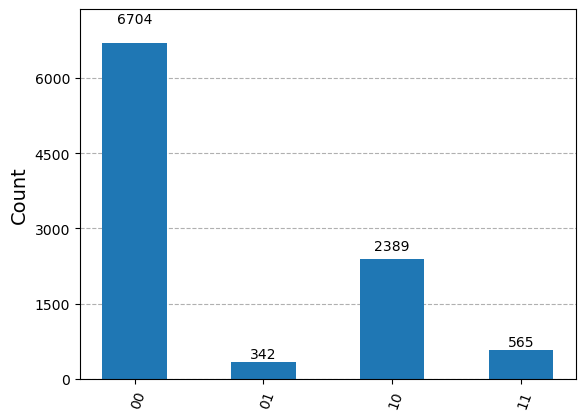

In [26]:
plot_histogram(pulse_results.get_counts())

### Tomography experiments

In [27]:
from rl_qoc.helper_functions import fidelity_from_tomography
from qiskit.quantum_info import Operator, Statevector

# Process tomography done through function below
q_env.backend.options.shots = 10000
fidelity = fidelity_from_tomography(
    [qc.remove_final_measurements(inplace=False)],
    q_env.backend,
    Operator(qc.remove_final_measurements(inplace=False)),
    q_env.physical_target_qubits,
)
print("Fidelity from tomography: ", fidelity)

Fidelity from tomography:  0.802727078986593


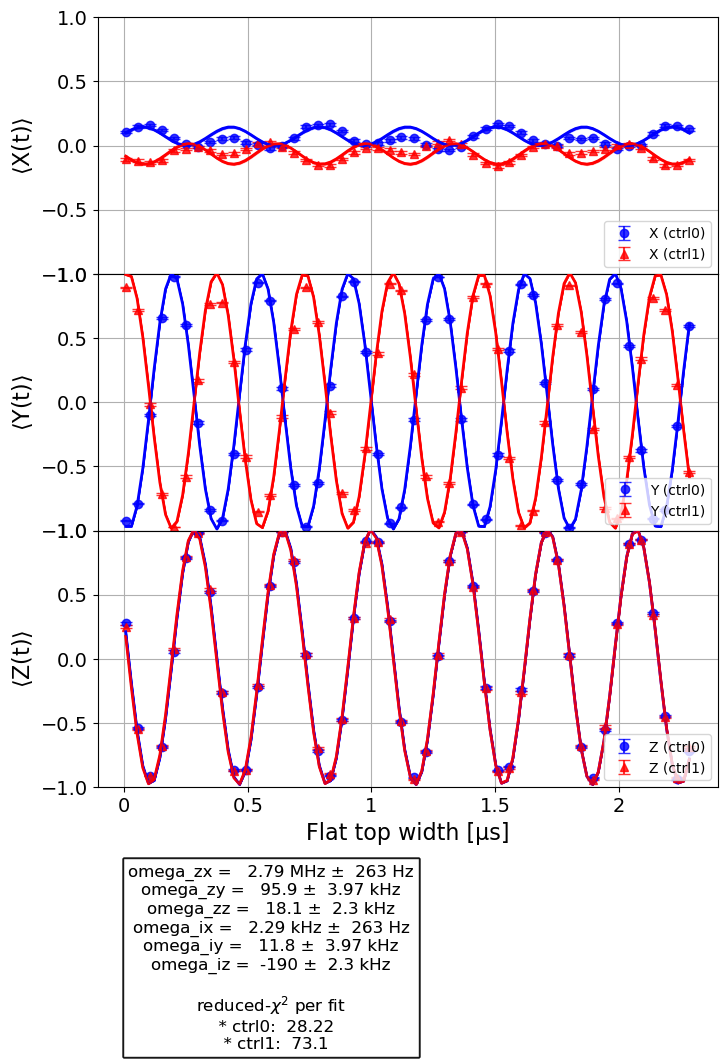

In [26]:
from qiskit_experiments.library.characterization.cr_hamiltonian import (
    EchoedCrossResonanceHamiltonian,
)

cr_ham = EchoedCrossResonanceHamiltonian(q_env.physical_target_qubits, q_env.backend)
cr_ham_data = cr_ham.run().block_for_results()
cr_ham_data.figure(0)

In [27]:
cr_ham.set_experiment_options(
    amp=q_env.optimal_action[0], amp_t=q_env.optimal_action[2]
)

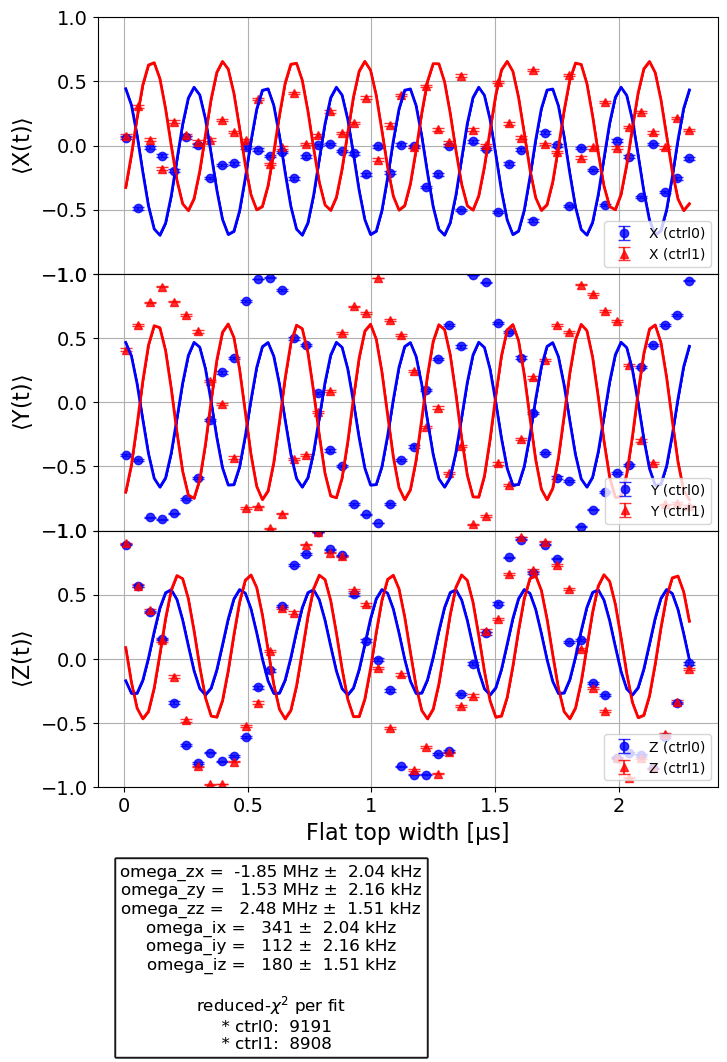

In [28]:
data2 = cr_ham.run().block_for_results()
data2.figure(0)

In [39]:
data2.analysis_results()

[AnalysisResult(name=omega_zx, value=2724784.924528828+/-217.90986269738983, device_components=[<Qubit(Q0)>, <Qubit(Q1)>], experiment_id=820d4966-69bf-4b73-b3d6-f9c74e2e53ee, result_id=732468b5-2775-4d60-ae15-225998a9f0e4, chisq=None, quality=bad, verified=False, extra={'unit': 'Hz', 'experiment': 'EchoedCrossResonanceHamiltonian', 'run_time': None}, tags=[], experiment id='820d4966-69bf-4b73-b3d6-f9c74e2e53ee'),
 AnalysisResult(name=omega_zy, value=82238.21091894565+/-3897.507251569241, device_components=[<Qubit(Q0)>, <Qubit(Q1)>], experiment_id=820d4966-69bf-4b73-b3d6-f9c74e2e53ee, result_id=f87f9c15-c032-447f-a2c3-fce1217c4c45, chisq=None, quality=bad, verified=False, extra={'unit': 'Hz', 'experiment': 'EchoedCrossResonanceHamiltonian', 'run_time': None}, tags=[], experiment id='820d4966-69bf-4b73-b3d6-f9c74e2e53ee'),
 AnalysisResult(name=omega_zz, value=20615.732425181992+/-2319.9775442634923, device_components=[<Qubit(Q0)>, <Qubit(Q1)>], experiment_id=820d4966-69bf-4b73-b3d6-f9c74

In [40]:
q_env.optimal_action

array([ 0.47572374, -0.9111626 ,  0.36890852,  0.46639013], dtype=float32)

In [78]:
q_env.backend.target.get_calibration("ecr_cal", (0, 1))

ScheduleBlock(ScheduleBlock(ScheduleBlock(ScheduleBlock(Play(GaussianSquare(duration=1168, sigma=64, width=912, amp=θ_0_, angle=θ_1_), ControlChannel(0)), Play(GaussianSquare(duration=1168, sigma=64, width=912, amp=θ_2_, angle=θ_3_), DriveChannel(1)), name="cr45p", transform=AlignLeft()), ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=6.1508371558, amp=0.11884648, angle=0), DriveChannel(0)), name="x", transform=AlignLeft()), ScheduleBlock(Play(GaussianSquare(duration=1168, sigma=64, width=912, amp=θ_0_, angle=θ_1_ + 3.14159265358979), ControlChannel(0)), Play(GaussianSquare(duration=1168, sigma=64, width=912, amp=θ_2_, angle=θ_3_ + 3.14159265358979), DriveChannel(1)), name="cr45m", transform=AlignLeft()), name="block25", transform=AlignSequential()), name="ecr", transform=AlignLeft()), name="custom_sched", transform=AlignLeft())

In [41]:
from qiskit_experiments.library.randomized_benchmarking import InterleavedRB

rb_exp = InterleavedRB(
    q_env.target.gate,
    q_env.physical_target_qubits,
    np.arange(1, 100, 10),
    q_env.backend,
    num_samples=10,
)
data_rb = rb_exp.run().block_for_results()
data_rb.figure(0)

AttributeError: 'QuantumCircuit' object has no attribute '_parameter_table'

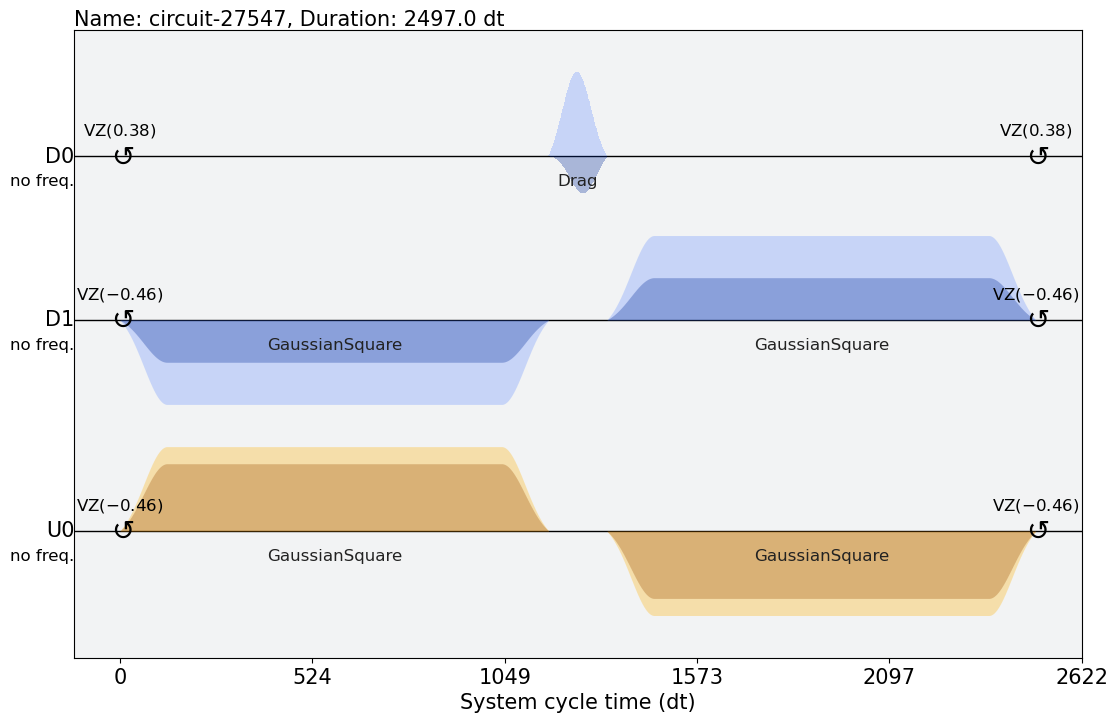

In [34]:
from qiskit import schedule

sched = schedule(qc, q_env.backend)
sched.draw()

In [35]:
from qiskit.transpiler import QubitProperties

v0 = 4.86e9
v1 = 4.97e9
q_env.backend.target.qubit_properties = [
    QubitProperties(frequency=v0),
    QubitProperties(frequency=v1),
]

In [45]:
from qiskit_dynamics.signals import Signal
from qiskit_dynamics.pulse.pulse_to_signals import InstructionToSignals

converter = InstructionToSignals(
    q_env.backend.dt,
    {
        "d0": q_env.backend.qubit_properties(0).frequency,
        "d1": q_env.backend.qubit_properties(1).frequency,
        "u0": q_env.backend.qubit_properties(1).frequency,
    },
    channels=["d0", "d1", "u0"],
)

In [21]:
q_env.simulate_pulse_circuit(q_env.circuits[0], q_env.optimal_action)

[0.6620462428284422]

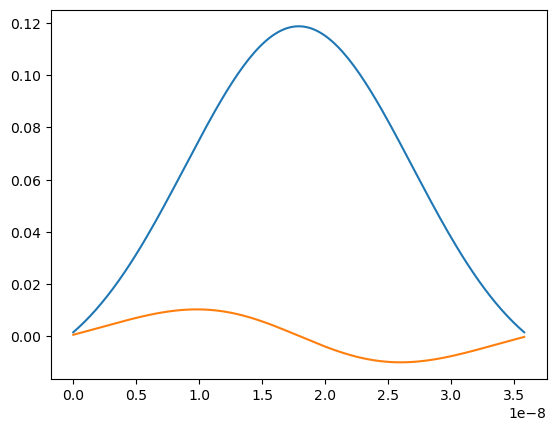

In [69]:
dt = q_env.backend.dt
I = np.real(converter.get_signals(sched)[0].samples)
Q = np.imag(converter.get_signals(sched)[0].samples)
t = np.linspace(0, sched.duration * dt, len(I))
plt.plot(t, I)
plt.plot(t, Q)

In [36]:
from qiskit.quantum_info import Statevector

simulate_pulse_schedule(
    q_env.backend,
    sched,
    target_unitary=Operator(qc.remove_final_measurements(inplace=False)),
    target_state=Statevector(qc.remove_final_measurements(inplace=False)),
)

{'unitary': Operator([[ 9.90754281e-02+0.16739531j,  1.90602070e-01+0.55657607j,
             7.17744126e-04-0.02377993j, -7.84963709e-01-0.04846116j],
           [ 4.94900454e-02+0.58480862j,  1.30851214e-02-0.17618445j,
             7.41521865e-01+0.2763154j , -5.19720038e-04+0.03376453j],
           [-4.94321148e-03-0.03822191j, -7.44592820e-01+0.26538405j,
             1.46603719e-02+0.17481314j, -4.38342831e-02+0.58647667j],
           [ 7.84569182e-01-0.0607531j , -1.87406264e-03+0.02946578j,
            -1.97119581e-01+0.55369421j,  9.99139693e-02-0.16574712j]],
          input_dims=(2, 2), output_dims=(2, 2)),
 'state': DensityMatrix([[ 0.03783713+1.96854877e-19j,  0.10279747-4.96557632e-02j,
                 -0.00688792+2.95938187e-03j,  0.06756174+1.37352341e-01j],
                [ 0.10279747+4.96557632e-02j,  0.34445039+8.16703213e-19j,
                 -0.02259714-9.99228547e-04j,  0.00329943+4.61829497e-01j],
                [-0.00688792-2.95938187e-03j, -0.02259714+9.992

In [32]:
np.linalg.norm(q_env.backend._dressed_states[:, 0])

0.9999999999999999